In [22]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import randint
from numpy.linalg import norm

from ipywidgets import interactive

from matplotlib import rcParams

In [26]:
rcParams['figure.figsize'] = (10, 8)

## Mars Lander Demo

The goal for this assigment is to safely land the "Mars Lander" shuttle. Mars Lander is guided by a program, and right now the failure rate for landing on the NASA simulator is unacceptable.

The simulator puts Mars Lander on a limited zone of Mars sky. The zone is 7000m wide and 3000m high.

There is a unique area of flat ground on the surface of Mars, which is at least 1000 meters wide. Every second, depending on the current flight parameters (location, speed, fuel ...), your program must provide the new desired tilt angle and thrust power of Mars Lander:

<img src="https://www.codingame.com/fileservlet?id=2635325710601">

Angle goes from -90 degrees to 90 degrees. Thrust power goes from 0 to 4.

<img src="https://www.codingame.com/fileservlet?id=957023678862" width="300px">

We will simulate a free fall without atmosphere. Gravity on Mars is 3.711 m/$^2$. For a thrust power of $X$, a force equivalent to $X$ m/s$2$ is generated and $X$ litres of fuel are consumed per second. As such, a thrust power of 4 in an almost vertical direction is needed to compensate for the gravity on Mars.

For a landing to be successful, the ship must:
- land on flat ground
- land in a vertical position (tilt angle = 0°)
- vertical speed must be limited (<40m/s in absolute value)
- horizontal speed must be limited (<20m/s in absolute value)

## Initialization

The function `mars_surface()` returns an array of size `(surfaceN, 2)` containing the points used to draw the surface of Mars and an integer `landing_site` giving the index of the row in this array containing the left-hand end of the flat landing site. 

Each row is a pair of integers `landX`,`landY` providing the coordinates of a ground point. By linking all the points together in a sequential fashion, you form the surface of Mars which is composed of several segments. For the first point, `landX = 0` and for the last point, `landX = 6999`

In [185]:
def mars_surface():
    surfaceN = randint(5, 15)
    land = np.zeros((surfaceN, 2), dtype=int)
    
    # first ensure there's a flat landing site at least 1000m long
    landing_site = randint(1, surfaceN-1)
    land[landing_site, 0] = randint(2000, 5000)
    land[landing_site+1, 0] = min(land[landing_site, 0] + randint(1000, 2000), 6999)
    land[landing_site+1, 1] = land[landing_site, 1] = randint(1, 1500)
    
    # fill in the rest of the terrain
    for i in range(landing_site):
        land[i, 0] = (land[landing_site, 0] / landing_site) * i
        land[i, 1] = randint(0, 1500)
    
    for i in range(landing_site + 2, surfaceN):
        land[i, 0] = (land[landing_site + 1, 0] + 
                      (7000 - land[landing_site + 1, 0]) / len(land[landing_site + 2:]) * 
                      (i - (landing_site + 1)))
        land[i, 1] = randint(0, 1500)
    
    # impose boundary conditions
    land[0, 0] = 0
    land[-1, 0] = 6999

    return land, landing_site

def plot_surface(land, landing_site):
    fig, ax = plt.subplots()
    ax.plot(land[:landing_site+1, 0], land[:landing_site+1, 1], 'k-')
    ax.plot(land[landing_site+1:, 0], land[landing_site+1:, 1], 'k-')
    ax.plot([land[landing_site, 0], land[landing_site+1, 0]], 
             [land[landing_site, 1], land[landing_site+1, 1]], 'k--')
    ax.set_xlim(0, 7000)
    ax.set_ylim(0, 3000)
    return ax

def plot_lander(land, landing_site, X, thrust=None, animate=False, step=10):
    if animate:
        def plot_frame(n=len(X)-1):
            ax = plot_surface(land, landing_site)
            ax.plot(X[:n, 0], X[:n, 1], 'b--')
            ax.plot(X[n, 0], X[n, 1], 'b^', ms=20)
            if thrust is not None:
                ax.plot([X[n, 0], X[n, 0] - 100*thrust[n, 0]],
                        [X[n, 1] - 100., X[n, 1] - 100. - 100*thrust[n, 1]], 
                       'r-', lw=10)
        return interactive(plot_frame, n=(0, len(X), step))
    else:
        ax = plot_surface(land, landing_site) 
        ax.plot(X[:, 0], X[:, 1], 'b--')
        ax.plot(X[-1, 0], X[-1, 1], 'b^')
        return ax


The `plot_surface()` function provided can be used to visualise the terrain. The flat landing site is shown with a dashed line. Try it out as follows:

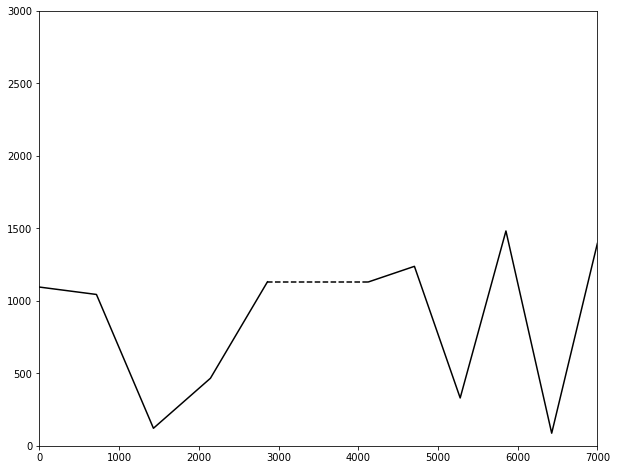

In [186]:
np.random.seed(42) # seed random number generator for reproducible results
land, landing_site = mars_surface()
plot_surface(land, landing_site);

To simulate the lander we need to be able to tell whether a given point `X = [x, y]` is above or below this surface.

In [187]:
def interpolate_surface(land, x):
    i,  = np.argwhere(land[:, 0] < x)[-1] # segment containing x is [i, i+1]
    m = (land[i+1, 1] - land[i, 1])/(land[i+1, 0] - land[i, 0]) # gradient
    x1, y1 = land[i, :] # point on line with eqn. y - y1 = m(x - x1) 
    return m*(x - x1) + y1

**Question 1. (10 marks)** Look at the `interpolate_surface()` function defined above. What do you think it does? Write a short description of how it works, suitable for inclusion as a comment in the code.

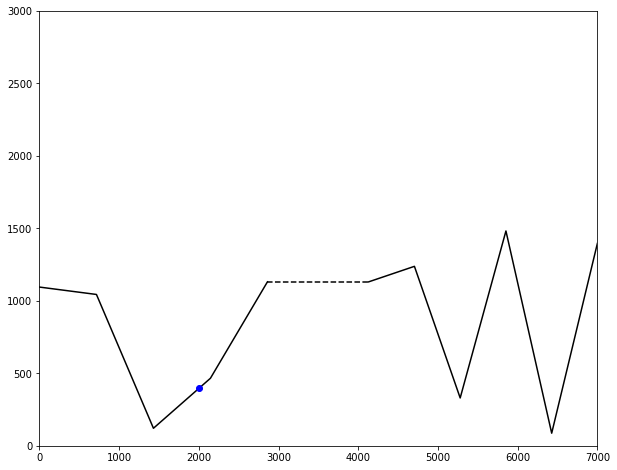

In [188]:
x = 2000 # try varying x and testing if function works as expected
y = interpolate_surface(land, x)
plot_surface(land, landing_site)
plt.plot(x, y, 'bo')

**Question 2. (10 marks)** Write a function `height(land, X)` which returns the vertical height of the lander above the surface of Mars defined by the array `land` when it has coordinates `X = [x, y]`. You will find your answer to **Q1** and the function `interpolate_surface()` useful.
    

In [189]:
def height(land, X):
    return X[1] - interpolate_surface(land, X[0])

In [190]:
assert abs(height(land, [1, land[0, 1]])) < 100.0 # height when on surface left edge should be close to zero
assert abs(height(land, [6999, land[-1, 1]])) < 100.0 # height when on surface at right edge should be close to zero

_land, _landing_site = mars_surface()
def _height(_land, X):
    return X[1] - interpolate_surface(_land, X[0])

points = np.zeros((10, 2))
points[:, 0] = randint(0, 7000, size=10)
points[:, 1] = randint(0, 3000, size=10)
for i in range(10):
    assert abs(height(_land, points[i, :]) - _height(_land, points[i, :])) < 1e-6

## Numerical Solution of the equations of motion

You are provided with a function `simulate()` which solves the equations of motion for the Mars lander using the semi-implicit Euler method presented in Lecture 4. It takes the initial position of the lander `X0` (2-element vector for `X` and `Y` coordinates), its initial velocity `V0`, and the array `land` and integer `landing_site` returned by `mars_surface()` as arguments. The horizontal and verticals accelerations of the lander are given by

$$\ddot{x} = P \cos \theta$$
$$\ddot{y} = -g + P \sin \theta$$

where $g$ is the accleration due to gravity and $\mathbf{t} = (P \sin \theta, P \cos \theta)$ is the thrust provided by the thruster with power $P$, $0 < P < 4$ at angle $\theta$, with $-90^\circ < \theta < 90^\circ$.

Additional optional arguments can be used to specify the amount of fuel, timestep `dt`, maximum number of steps `T`, whether to enable an autopilot to control the thruster power (not used initially, see below) and how often to print output.

Compare this code to the `symplectic_euler()` function given in Lecture 4 - the only differences are in initialisation, autopilot (see below) and error checking, with the core algorithm unchanged.

In [191]:
g = 3.711 # m/s^2, gravity on Mars

def simulate(X0, V0, land, landing_site, 
             fuel=200, dt=0.1, Nstep=1000, 
             autopilot=None, print_interval=100):
    
    n = len(X0)       # number of degrees of freedom (2 here)
    X = X0.copy()     # current position
    V = V0.copy()     # current velocity
    Xs = np.zeros((Nstep, n)) # position history (trajectory) 
    Vs = np.zeros((Nstep, n)) # velocity history
    thrust = np.zeros((Nstep, n)) # thrust history
    success = False
    fuel_warning_printed = False
    rotate = 0           # degrees, initial angle
    power = 0            # m/s^2, initial thrust power    
    
    for i in range(Nstep):
        Xs[i, :] = X     # Store positions
        Vs[i, :] = V     # Store velocities
        
        if autopilot is not None:
            # call user-supplied function to set `rotate` and `power`
            rotate, power = autopilot(i, X, V, fuel, rotate, power)
            assert abs(rotate) <= 90
            assert 0 <= power <= 4
        
            rotate_rad = rotate * np.pi / 180.0 # degrees to radians
            thrust[i, :] = power * np.array([np.sin(rotate_rad), 
                                             np.cos(rotate_rad)])
            if fuel <= 0: 
                if not fuel_warning_printed:
                    print("Fuel empty! Setting thrust to zero")
                    fuel_warning_printed = True
                thrust[i, :] = 0
            else:
                fuel -= power*dt
        
        A = np.array([0, -g]) + thrust[i, :] # acceleration
        V += A * dt                          # update velocities
        X += V * dt                          # update positions
        
        if i % print_interval == 0: 
            print(f"i={i:03d} X=[{X[0]:8.3f} {X[1]:8.3f}] V=[{V[0]:8.3f} {V[1]:8.3f}]"
                  f" thrust=[{thrust[i, 0]:8.3f} {thrust[i, 1]:8.3f}] fuel={fuel:8.3f}")
        
        # check for safe or crash landing
        if X[1] < interpolate_surface(land, X[0]):
            if not (land[landing_site, 0] <= X[0] and X[0] <= land[landing_site + 1, 0]):
                print("crash! did jot land on flat ground!")
            elif rotate != 0:
                print("crash! did not land in a vertical position (tilt angle = 0 degrees)")
            elif abs(V[1]) >= 40:
                print("crash! vertical speed must be limited (<40m/s in absolute value), got ", abs(V[1]))
            elif abs(V[0]) >= 20:
                print("crash! horizontal speed must be limited (<20m/s in absolute value), got ", abs(V[0]))
            else:
                print("safe landing - well done!")
                success = True
            Nstep = i
            break
    
    return Xs[:Nstep,:], Vs[:Nstep,:], thrust[:Nstep,:], success

Let's try it out for a simplified case where the lander starts directly above the landing site and the thruster is not used:

In [192]:
X0 = [(land[landing_site+1, 0] + land[landing_site, 0]) // 2, 3000]
V0 = [0.0, 0.0]
Xs, Vs, thrust, success = simulate(X0, V0, land, landing_site)
plot_lander(land, landing_site, Xs, thrust, animate=True, step=10)

i=000 X=[3495.000 2999.963] V=[   0.000   -0.371] thrust=[   0.000    0.000] fuel= 200.000
i=100 X=[3495.000 2808.846] V=[   0.000  -37.481] thrust=[   0.000    0.000] fuel= 200.000
i=200 X=[3495.000 2246.630] V=[   0.000  -74.591] thrust=[   0.000    0.000] fuel= 200.000
i=300 X=[3495.000 1313.313] V=[   0.000 -111.701] thrust=[   0.000    0.000] fuel= 200.000
crash! vertical speed must be limited (<40m/s in absolute value), got  117.63869999999959


interactive(children=(IntSlider(value=315, description='n', max=316, step=10), Output()), _dom_classes=('widge…

We get a crash landing as the vertical speed exceeds the maximum acceptable value of 40 m/s.

**Question 3. (20 marks)** Calculate the potential energy and kinetic energies of the lander during this trajectory via the expressions

$$V = mgh$$
$$T = \frac 12 mv^2$$
$$E = T + V$$

where  $V$, $T$ and $E$ denote the potential, kinetic and total energies respectively, and $m=100$ kg is the mass of the lander, $h$ is its height and $v$ is is speed and $g$ is the acceleration due to gravity (3.711 m/s$^2$ on Mars),

Adjust the timestep `dt` passed to `simulate()` to ensure there is less than a 0.1% drift in the total energy over 1 second of simulated time, i.e. $\Delta E/E < 10^{-3}$ . You may find it helpful to plot a graph of the relative error in `E` as a function of time. 

To pass the tests you must store the time in an array named `t` and the total energy in an array named `E`. 

Here's some skeleton code to get you started:

```julia
m = 100. # mass of lander in kg
dt = 1.0 # timestep, you'll need to adjust this
Nstep = Int(1.0/dt)+1 # number of steps required for 1 second of simulated time

# run the simulation
Xs, Vs, thrust, success = simulate(X0, V0, land, landing_site, dt=dt, Nstep=Nstep)

t = ...
V = ...
T = ...
E = ...
```

i=000 X=[3495.000 2999.963] V=[   0.000   -0.371] thrust=[   0.000    0.000] fuel= 200.000


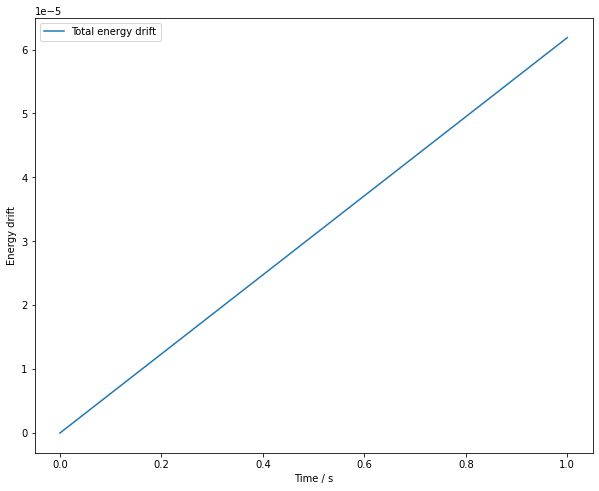

In [193]:
m = 100. # mass of lander in kg
dt = 0.1
Nstep = int((1.0 / dt) + 1) # number of steps required for 1 second of simulated time
Xs, Vs, thrust, success = simulate(X0, V0, land, landing_site, dt=dt, Nstep=Nstep)

t = np.array([dt*i for i in range(Nstep) ])
V = np.array([ m*g*Xs[i, 1] for i in range(Nstep) ])
T = np.array([ 0.5*m*norm(Vs[i, :])**2 for i in range(Nstep) ])
E = T + V

fig, ax = plt.subplots()
ax.plot(t, abs(E - E[0])/E[0], label="Total energy drift")
ax.set_xlabel('Time / s')
ax.set_ylabel('Energy drift')
ax.legend()

In [194]:
assert t[0] == 0.0
assert t[-1] >= 1.0
assert len(t) == len(E) == Nstep
assert abs(E[-1] - E[0])/E[0] < 1e-3

## Designing an autopilot to control the lander

To control the lander, you need define a function `autopilot()` which accepts 5 arguments: 

- `i` is an integer giving step count - e.g. useful for printing debugging inforation every 100 steps.
- `X` is a 2D vector containing the current coordinates of Mars Lander (in meters).
- `V` is 2D vector containing the horizontal and vertical speed of Mars Lander (in m/s). These can be negative depending on the direction of the lander.
- `fuel` is the remaining quantity of fuel in litres. When there is no more fuel, the power of thrusters falls to zero.
- `rotate` is the angle of rotation of Mars Lander expressed in degrees.
- `power` is the thrust power of the landing ship.

Your function must return two integers `(rotate, power)`, where

- `rotate` is the desired rotation angle for Mars Lander, in degrees. 
- `power` is the desired thrust power. 0 = off. 4 = maximum power. 

Here is a template `dummy_autopilot()` which does nothing - note that this will invariably lead to a crash landing!

In [195]:
def dummy_autopilot(i, X, V, fuel, rotate, power):
   return (rotate, power) # do nothing

Pass the `autopilot` function as an extra argument to `simulate()` to turn it on - be sure to use the timestep `dt` that you determined in Q3:

In [196]:
X0 = [(land[landing_site+1, 0] + land[landing_site, 0]) // 2, 3000]
V0 = [0., 0.]
Xs, Vs, thrust, success = simulate(X0, V0, land, landing_site, dt=dt, autopilot=dummy_autopilot)
plot_lander(land, landing_site, Xs, thrust, animate=True, step=10)

i=000 X=[3495.000 2999.963] V=[   0.000   -0.371] thrust=[   0.000    0.000] fuel= 200.000
i=100 X=[3495.000 2808.846] V=[   0.000  -37.481] thrust=[   0.000    0.000] fuel= 200.000
i=200 X=[3495.000 2246.630] V=[   0.000  -74.591] thrust=[   0.000    0.000] fuel= 200.000
i=300 X=[3495.000 1313.313] V=[   0.000 -111.701] thrust=[   0.000    0.000] fuel= 200.000
crash! vertical speed must be limited (<40m/s in absolute value), got  117.63869999999959


interactive(children=(IntSlider(value=315, description='n', max=316, step=10), Output()), _dom_classes=('widge…

As expected, we still get a crash landing as we have not fired the thruster at all. If you reduce the initial height of the lander you should be able to get a successful landing, but of course this is cheating!

You can experiment with writing your own autopilot, or proceed to the next section for some suggestions.

## Proportional control

We would like to design a suitable strategy for the autopilot, whose job is to adjust automatically the lander’s controls (thrust, and later the angle as well) to bring it safely to the surface. There is a powerful engineering discipline, **control theory**, that provides us with the necessary tools to do this. We will take a less-than-totally- rigorous look at a straightforward technique called **proportional control**. You can read more about this on [Wikipedia](https://en.wikipedia.org/wiki/PID_controller) or elsewhere.

We want to use the engine’s thrust to control the rate of descent. Suppose our strategy is that the descent rate should decrease linearly as the lander approaches the surface, i.e. with target vertical velocity

$$ v_y^\mathrm{target} = −(c + K_h h) $$

where $h$ is the lander’s altitude and $K_h$ is a positive constant. This seems reasonable, since the descent rate should then approach $c$ m/s as the lander touches down. If we set $c = 10$ m/s we should be safely within the 40 m/s limit. We can define an error term

$$ e = v_y^\mathrm{target} - v_y = −(c + K_h h + v_y)$$

which is positive if the lander is descending too quickly and negative if the lander is descending too slowly.

The instantaneous output of a proportional controller is then

$$P_\mathrm{out} = K_p e$$

where $K_p$ is a positive constant known as the controller gain. Ideally, we would use $P_\mathrm{out}$ to control directly the engine’s throttle, but here we must diverge a little from perfect proportional control theory, since whereas $P_\mathrm{out}$ might take any real value representing arbitrary forward and reverse thrust, the lander’s engine is only capable of delivering a limited amount of forward thrust corresponding to throttle values in the range 0 to 4.

**Question 4. (15 marks for infinite fuel + 20 marks for limited fuel)** Implement this scheme in an autopilot function named `proportional_autopilot()` and experiment with different values of $K_h$ and $K_p$. You will need to resort to trial and error when tuning $K_h$ and $K_p$. Initially, you might find it helpful to give yourself an infinite fuel supply (pass `fuel=Inf` to `simulate()`), though you should eventually manage to find suitable values for $K_h$ that bring the lander safely down with the supplied amount of fuel (`fuel=200`). 

Here is a skeleton for your function:

```python
def proportional_autopilot(i, X, V, fuel, rotate, power):
    c = 10.0 # target landing speed, m/s
    K_h = ...
    K_p = ...
    power = ... # set the thrust, must be 0 < power < 4
    rotate = 0 # rotation angle, -90 < rotate < 90, not needed until bonus question!
    return (rotate, power)
```

In [197]:
def proportional_autopilot(i, X, V, fuel, rotate, power):
    c = 10.0 # target landing speed, m/s
    K_h = 0.01
    K_p = 0.2
    h = height(land, X)
    e = - (c + K_h*h + V[1])
    Pout = K_p*e
    power = min(max(Pout, 0.0), 4.0)
    if i % 100 == 0:
        print(f'e={e:8.3f} Pout={Pout:8.3f} power={power:8.3f}')
    return (rotate, power)

While testing, you can use the cell below to run the simulation and visualise your trajectory:

In [198]:
X0 = [(land[landing_site+1, 0] + land[landing_site, 0]) // 2, 3000]
V0 = [0., 0.]
Xs, Vs, thrust, success = simulate(X0, V0, land, landing_site, dt=0.1, Nstep=2000, 
                                   autopilot=proportional_autopilot, fuel=np.inf)
plot_lander(land, landing_site, Xs, thrust, animate=True, step=10)

e= -28.690 Pout=  -5.738 power=   0.000
i=000 X=[3495.000 2999.963] V=[   0.000   -0.371] thrust=[   0.000    0.000] fuel=     inf
e=   8.116 Pout=   1.623 power=   1.623
i=100 X=[3495.000 2811.056] V=[   0.000  -35.161] thrust=[   0.000    1.623] fuel=     inf
e=  18.947 Pout=   3.789 power=   3.789
i=200 X=[3495.000 2409.258] V=[   0.000  -41.764] thrust=[   0.000    3.789] fuel=     inf
e=  20.566 Pout=   4.113 power=   4.000
i=300 X=[3495.000 2002.621] V=[   0.000  -39.293] thrust=[   0.000    4.000] fuel=     inf
e=  21.462 Pout=   4.292 power=   4.000
i=400 X=[3495.000 1624.288] V=[   0.000  -36.403] thrust=[   0.000    4.000] fuel=     inf
e=  22.070 Pout=   4.414 power=   4.000
i=500 X=[3495.000 1274.856] V=[   0.000  -33.513] thrust=[   0.000    4.000] fuel=     inf
safe landing - well done!


interactive(children=(IntSlider(value=543, description='n', max=544, step=10), Output()), _dom_classes=('widge…

You may also find it useful to plot the actual and target speed as a function of height by adapting the code below

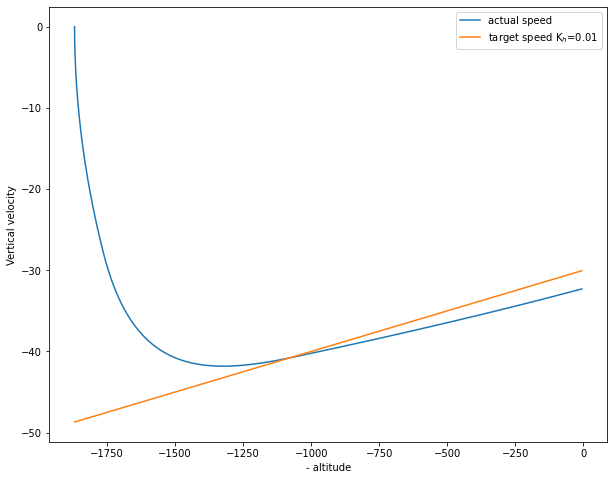

In [209]:
c = 30.
K_h = 0.01 # fill in your value of K_h here

h = np.array([height(land, Xs[i, :]) for i in range(len(Xs))])

fig, ax = plt.subplots()
ax.plot(-h, Vs[:, 1], label="actual speed")
ax.set_xlabel("- altitude")
ax.set_ylabel("Vertical velocity")
ax.plot(-h, -(c + K_h*h), label=f"target speed K$_h$={K_h}")
ax.legend()

Here are the test cases, first with infinite fuel [15 marks] and then with 200 liters of fuel (a bit harder!) [20 marks]

In [211]:
# first test with infinite fuel
X0 = [(land[landing_site+1, 0] + land[landing_site, 0]) // 2, 3000]
V0 = [0., 0., ]
Xs, Vs, thrust, success = simulate(X0, V0, land, landing_site, dt=0.1, Nstep=2000, 
                                   autopilot=proportional_autopilot, fuel=np.inf)
assert success

e= -28.690 Pout=  -5.738 power=   0.000
i=000 X=[3495.000 2999.963] V=[   0.000   -0.371] thrust=[   0.000    0.000] fuel=     inf
e=   8.116 Pout=   1.623 power=   1.623
i=100 X=[3495.000 2811.056] V=[   0.000  -35.161] thrust=[   0.000    1.623] fuel=     inf
e=  18.947 Pout=   3.789 power=   3.789
i=200 X=[3495.000 2409.258] V=[   0.000  -41.764] thrust=[   0.000    3.789] fuel=     inf
e=  20.566 Pout=   4.113 power=   4.000
i=300 X=[3495.000 2002.621] V=[   0.000  -39.293] thrust=[   0.000    4.000] fuel=     inf
e=  21.462 Pout=   4.292 power=   4.000
i=400 X=[3495.000 1624.288] V=[   0.000  -36.403] thrust=[   0.000    4.000] fuel=     inf
e=  22.070 Pout=   4.414 power=   4.000
i=500 X=[3495.000 1274.856] V=[   0.000  -33.513] thrust=[   0.000    4.000] fuel=     inf
safe landing - well done!


In [213]:
# now test with fuel=200
X0 = [(land[landing_site+1, 0] + land[landing_site, 0]) // 2, 3000]
V0 = [0., 0., ]
Xs, Vs, thrust, success = simulate(X0, V0, land, landing_site, dt=0.1, Nstep=2000, 
                                   autopilot=proportional_autopilot, fuel=200)
assert success

e= -28.690 Pout=  -5.738 power=   0.000
i=000 X=[3495.000 2999.963] V=[   0.000   -0.371] thrust=[   0.000    0.000] fuel= 200.000
e=   8.116 Pout=   1.623 power=   1.623
i=100 X=[3495.000 2811.056] V=[   0.000  -35.161] thrust=[   0.000    1.623] fuel= 197.679
e=  18.947 Pout=   3.789 power=   3.789
i=200 X=[3495.000 2409.258] V=[   0.000  -41.764] thrust=[   0.000    3.789] fuel= 167.173
e=  20.566 Pout=   4.113 power=   4.000
i=300 X=[3495.000 2002.621] V=[   0.000  -39.293] thrust=[   0.000    4.000] fuel= 127.592
e=  21.462 Pout=   4.292 power=   4.000
i=400 X=[3495.000 1624.288] V=[   0.000  -36.403] thrust=[   0.000    4.000] fuel=  87.592
e=  22.070 Pout=   4.414 power=   4.000
i=500 X=[3495.000 1274.856] V=[   0.000  -33.513] thrust=[   0.000    4.000] fuel=  47.592
safe landing - well done!


**Question 5. (10 marks)** Write a short paragraph to explain the role of $K_h$: too high and the lander crashes, too low and it runs out of fuel, but why? 

YOUR ANSWER HERE

**Question 6. (5 marks for each part)** Adjust your autopilot to work cope with:

1. random vertical starting positions between 1500 and 3000m [5 marks]
2. random changes in the initial vertical velocity ($-50 < v_y < 50$ m/s) [5 marks]
3. different random Martian surfaces. [5 marks]

To pass each of the three tests you need to achieve at least an 80% success rate over 20 trials. You should be able to find common values of $K_h$ and $K_p$ that work for all three tests.

In [217]:
# Test 1. Random vertical starting positions
np.random.seed(123) # seed random number generator for reproducible results
land, landing_site = mars_surface()

trials = 20
count = 0
for i in range(trials):
    X0 = [(land[landing_site+1, 0] + land[landing_site, 0]) // 2, randint(1500, 3000)]
    V0 = [0., 0.]
    print(f'X0={X0} V0={V0}')
    Xs, Vs, thrust, success = simulate(X0, V0, land, landing_site, dt=0.1, Nstep=2000, 
                                       autopilot=proportional_autopilot, fuel=200)
    count += success
    print()

print(f'count/trials = {count/trials}')
assert count/trials > 0.8 # require 80% success rate

X0=[5060, 2138] V0=[0.0, 0.0]
e= -20.960 Pout=  -4.192 power=   0.000
i=000 X=[5060.000 2137.963] V=[   0.000   -0.371] thrust=[   0.000    0.000] fuel= 200.000
e=  11.910 Pout=   2.382 power=   2.382
i=100 X=[5060.000 1957.308] V=[   0.000  -31.227] thrust=[   0.000    2.382] fuel= 193.746
e=  19.176 Pout=   3.835 power=   3.835
i=200 X=[5060.000 1615.042] V=[   0.000  -34.929] thrust=[   0.000    3.835] fuel= 160.338
e=  20.115 Pout=   4.023 power=   4.000
i=300 X=[5060.000 1276.898] V=[   0.000  -32.468] thrust=[   0.000    4.000] fuel= 120.767
safe landing - well done!

X0=[5060, 1547] V0=[0.0, 0.0]
e= -15.050 Pout=  -3.010 power=   0.000
i=000 X=[5060.000 1546.963] V=[   0.000   -0.371] thrust=[   0.000    0.000] fuel= 200.000
e=  13.895 Pout=   2.779 power=   2.779
i=100 X=[5060.000 1378.635] V=[   0.000  -27.382] thrust=[   0.000    2.779] fuel= 189.901
e=  19.221 Pout=   3.844 power=   3.844
i=200 X=[5060.000 1084.996] V=[   0.000  -29.667] thrust=[   0.000    3.844] fuel= 155.

e=  21.917 Pout=   4.383 power=   4.000
i=500 X=[5060.000 1143.374] V=[   0.000  -32.935] thrust=[   0.000    4.000] fuel=  47.014
safe landing - well done!

X0=[5060, 2096] V0=[0.0, 0.0]
e= -20.540 Pout=  -4.108 power=   0.000
i=000 X=[5060.000 2095.963] V=[   0.000   -0.371] thrust=[   0.000    0.000] fuel= 200.000
e=  12.074 Pout=   2.415 power=   2.415
i=100 X=[5060.000 1915.995] V=[   0.000  -30.975] thrust=[   0.000    2.415] fuel= 193.494
e=  19.183 Pout=   3.837 power=   3.837
i=200 X=[5060.000 1577.111] V=[   0.000  -34.556] thrust=[   0.000    3.837] fuel= 159.965
e=  20.093 Pout=   4.019 power=   4.000
i=300 X=[5060.000 1242.666] V=[   0.000  -32.102] thrust=[   0.000    4.000] fuel= 120.401
safe landing - well done!

count/trials = 1.0


In [219]:
# Test 2 - random initial vertical velocity

np.random.seed(123) # seed random number generator for reproducible results
land, landing_site = mars_surface()

trials = 20
count = 0
for i in range(trials):
    X0 = [(land[landing_site+1, 0] + land[landing_site, 0]) // 2, randint(1500, 3000)]
    V0 = [0., np.random.uniform(-50, 50)]  
    print(f'X0={X0} V0={V0}')
    Xs, Vs, thrust, success = simulate(X0, V0, land, landing_site, dt=0.1, Nstep=2000, 
                                       autopilot=proportional_autopilot, fuel=200)
    count += success
    print()

print(f'count/trials = {count/trials}')
assert count/trials > 0.8 # require 80% success rate

X0=[5060, 2138] V0=[0.0, -36.004923736961544]
e=  15.045 Pout=   3.009 power=   3.009
i=000 X=[5060.000 2134.392] V=[   0.000  -36.075] thrust=[   0.000    3.009] fuel= 199.699
e=  19.706 Pout=   3.941 power=   3.941
i=100 X=[5060.000 1762.132] V=[   0.000  -36.921] thrust=[   0.000    3.941] fuel= 163.435
e=  20.449 Pout=   4.090 power=   4.000
i=200 X=[5060.000 1406.861] V=[   0.000  -34.102] thrust=[   0.000    4.000] fuel= 123.506
e=  20.826 Pout=   4.165 power=   4.000
i=300 X=[5060.000 1080.431] V=[   0.000  -31.212] thrust=[   0.000    4.000] fuel=  83.506
safe landing - well done!

X0=[5060, 2442] V0=[0.0, 12.731700933761672]
e= -36.732 Pout=  -7.346 power=   0.000
i=000 X=[5060.000 2443.236] V=[   0.000   12.361] thrust=[   0.000    0.000] fuel= 200.000
e=   0.964 Pout=   0.193 power=   0.193
i=100 X=[5060.000 2379.442] V=[   0.000  -24.715] thrust=[   0.000    0.193] fuel= 199.965
e=  17.765 Pout=   3.553 power=   3.553
i=200 X=[5060.000 2040.068] V=[   0.000  -37.800] thrust

e=  19.771 Pout=   3.954 power=   3.954
i=200 X=[5060.000 1061.377] V=[   0.000  -29.971] thrust=[   0.000    3.954] fuel= 136.606
safe landing - well done!

X0=[5060, 2503] V0=[0.0, 25.03787047668483]
e= -49.648 Pout=  -9.930 power=   0.000
i=000 X=[5060.000 2505.467] V=[   0.000   24.667] thrust=[   0.000    0.000] fuel= 200.000
e= -13.168 Pout=  -2.634 power=   0.000
i=100 X=[5060.000 2564.729] V=[   0.000  -12.443] thrust=[   0.000    0.000] fuel= 200.000
e=  14.938 Pout=   2.988 power=   2.988
i=200 X=[5060.000 2283.014] V=[   0.000  -37.458] thrust=[   0.000    2.988] fuel= 187.904
e=  19.753 Pout=   3.951 power=   3.951
i=300 X=[5060.000 1896.639] V=[   0.000  -38.314] thrust=[   0.000    3.951] fuel= 151.650
e=  20.607 Pout=   4.121 power=   4.000
i=400 X=[5060.000 1527.664] V=[   0.000  -35.470] thrust=[   0.000    4.000] fuel= 111.697
e=  21.121 Pout=   4.224 power=   4.000
i=500 X=[5060.000 1187.560] V=[   0.000  -32.580] thrust=[   0.000    4.000] fuel=  71.697
safe landing

In [220]:
# Test 3 - random Martian surfaces

np.random.seed(123) # seed random number generator for reproducible results

trials = 20
count = 0
for i in range(trials):
    land, landing_site = mars_surface()
    X0 = [(land[landing_site+1, 0] + land[landing_site, 0]) // 2, randint(1500, 3000)]
    V0 = [0., 0.] 
    print(f'X0={X0} V0={V0}')
    Xs, Vs, thrust, success = simulate(X0, V0, land, landing_site, dt=0.1, Nstep=2000, 
                                       autopilot=proportional_autopilot, fuel=200)
    count += success
    print()

print(f'count/trials = {count/trials}')
assert count/trials > 0.8 # require 80% success rate

X0=[5060, 2138] V0=[0.0, 0.0]
e= -20.960 Pout=  -4.192 power=   0.000
i=000 X=[5060.000 2137.963] V=[   0.000   -0.371] thrust=[   0.000    0.000] fuel= 200.000
e=  11.910 Pout=   2.382 power=   2.382
i=100 X=[5060.000 1957.308] V=[   0.000  -31.227] thrust=[   0.000    2.382] fuel= 193.746
e=  19.176 Pout=   3.835 power=   3.835
i=200 X=[5060.000 1615.042] V=[   0.000  -34.929] thrust=[   0.000    3.835] fuel= 160.338
e=  20.115 Pout=   4.023 power=   4.000
i=300 X=[5060.000 1276.898] V=[   0.000  -32.468] thrust=[   0.000    4.000] fuel= 120.767
safe landing - well done!

X0=[3554, 2846] V0=[0.0, 0.0]
e= -37.340 Pout=  -7.468 power=   0.000
i=000 X=[3554.000 2845.963] V=[   0.000   -0.371] thrust=[   0.000    0.000] fuel= 200.000
e=   1.595 Pout=   0.319 power=   0.319
i=100 X=[3554.000 2654.863] V=[   0.000  -37.400] thrust=[   0.000    0.319] fuel= 199.919
e=  18.364 Pout=   3.673 power=   3.673
i=200 X=[3554.000 2194.949] V=[   0.000  -49.246] thrust=[   0.000    3.673] fuel= 174.

e=  20.487 Pout=   4.097 power=   4.000
i=400 X=[3061.000  580.039] V=[   0.000  -30.539] thrust=[   0.000    4.000] fuel=  81.728
safe landing - well done!

X0=[4629, 2149] V0=[0.0, 0.0]
e= -24.300 Pout=  -4.860 power=   0.000
i=000 X=[4629.000 2148.963] V=[   0.000   -0.371] thrust=[   0.000    0.000] fuel= 200.000
e=  10.462 Pout=   2.092 power=   2.092
i=100 X=[4629.000 1963.780] V=[   0.000  -33.105] thrust=[   0.000    2.092] fuel= 195.624
e=  19.105 Pout=   3.821 power=   3.821
i=200 X=[4629.000 1595.114] V=[   0.000  -37.893] thrust=[   0.000    3.821] fuel= 163.302
e=  20.309 Pout=   4.062 power=   4.000
i=300 X=[4629.000 1227.450] V=[   0.000  -35.400] thrust=[   0.000    4.000] fuel= 123.699
e=  20.816 Pout=   4.163 power=   4.000
i=400 X=[4629.000  888.044] V=[   0.000  -32.510] thrust=[   0.000    4.000] fuel=  83.699
safe landing - well done!

X0=[3911, 2231] V0=[0.0, 0.0]
e= -18.130 Pout=  -3.626 power=   0.000
i=000 X=[3911.000 2230.963] V=[   0.000   -0.371] thrust=[  

## Bonus Question

Extend your autopilot to cope with the more diffcult case where the launcher starts at a random $(x, y)$ position within 1000m either side of the centre of the landing zone.

## Further ideas for extensions

- Extend to the fully random case where the initial position can be any point $\mathbf{X}_0 = (x, y)$ with $0 < x < 7000$ m and $1500 < y < 3000$ m. You may have to analyse the terrain to avoid crashing into any mountains!
- Add random horizontal wind forces and improve the autopilot to compensate for these - how large can these force be before your autopilot loses control?
- Extend the autopilot to cover orbital re-entry with initial velocities $\mathbf{V}_0 = (v_x, v_y)$ in the range $-500 < v_x < 500$ m/s, $-500 < v_y < 500$ m/s to model orbital re-entryas well as the final descent stage
- How might you tune your autopilot to achieve (i) minimal fuel usage, (ii) minimal descent time, (iii) minimal peak acceleration?